<a href="https://colab.research.google.com/github/AlexanderPidodnya/TF_ud_course/blob/first/Using_CNNs%2C_GRUs%2C_LSTMs_with_a_larger_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import io
import pandas as pd


In [2]:
URL = 'https://dl.fbaipublicfiles.com/glue/data/SST-2.zip'
path = tf.keras.utils.get_file('SST-2.zip', origin = URL)
path

7454720/7439277 [==============================] - 0s 0us/step


'/root/.keras/datasets/SST-2.zip'

In [3]:
!mkdir dataset

In [5]:
!unzip -q {path} -d /content/dataset

In [25]:
df_train= pd.read_csv('/content/dataset/SST-2/train.tsv', sep = '\t')
df_test = pd.read_csv('/content/dataset/SST-2/dev.tsv', sep = '\t')

In [26]:
d_sent = tf.data.Dataset.from_tensor_slices(df_train['sentence'])
d_lab = tf.data.Dataset.from_tensor_slices(df_train['label'])
dataset_train = tf.data.Dataset.zip((d_sent, d_lab))

d_sent = tf.data.Dataset.from_tensor_slices(df_test['sentence'])
d_lab = tf.data.Dataset.from_tensor_slices(df_test['label'])
dataset_validation = tf.data.Dataset.zip((d_sent, d_lab))

training_reviews = []
training_labels = []

validation_reviews = []
validation_labels = []

for d in dataset_train.take(40000):
  review, label = d[0], d[1]
  training_reviews.append(str(review.numpy()))
  training_labels.append(float(label.numpy()))

print('\nNumber of training reviews is:', len(training_reviews))

for d in dataset_validation:
  review, label = d[0], d[1]
  validation_reviews.append(str(review.numpy()))
  validation_labels.append(float(label.numpy()))

print('\nNumber of validation reviews is:', len(validation_reviews))


Number of training reviews is: 40000

Number of validation reviews is: 872


In [28]:
print(training_reviews[:5], training_labels[:5])
print(validation_reviews[:5], validation_labels[:5])

["b'hide new secretions from the parental units '", "b'contains no wit , only labored gags '", "b'that loves its characters and communicates something rather beautiful about human nature '", "b'remains utterly satisfied to remain the same throughout '", "b'on the worst revenge-of-the-nerds clich\\xc3\\xa9s the filmmakers could dredge up '"] [0.0, 0.0, 1.0, 0.0, 0.0]
['b"it \'s a charming and often affecting journey . "', "b'unflinchingly bleak and desperate '", "b'allows us to hope that nolan is poised to embark a major career as a commercial yet inventive filmmaker . '", 'b"the acting , costumes , music , cinematography and sound are all astounding given the production \'s austere locales . "', 'b"it \'s slow -- very , very slow . "'] [1.0, 0.0, 1.0, 1.0, 0.0]


#Tokenize the words and sequence the sentences

In [8]:
vocab_size = 4000
embedding_dim = 16
max_length = 50
trunc_type = 'post'
pad_type = 'post'
OOV_tok = '<OOV>'

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token = OOV_tok)
tokenizer.fit_on_texts(training_reviews)
word_index = tokenizer.word_index

#Pad the sequences

In [29]:
training_sequences = tokenizer.texts_to_sequences(training_reviews)
training_padded = pad_sequences(training_sequences, maxlen=max_length, truncating=trunc_type, padding=pad_type)

validation_sequences = tokenizer.texts_to_sequences(validation_reviews)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, truncating=trunc_type, padding=pad_type)

training_labels_final = np.array(training_labels)
validation_labels_final = np.array(validation_labels)


#Create the model using an Embedding

In [30]:
model = tf.keras.Sequential([
  tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
  tf.keras.layers.GlobalAveragePooling1D(),
  tf.keras.layers.Dense(6, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 16)            64000     
                                                                 
 global_average_pooling1d_2   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_2 (Dense)             (None, 6)                 102       
                                                                 
 dense_3 (Dense)             (None, 1)                 7         
                                                                 
Total params: 64,109
Trainable params: 64,109
Non-trainable params: 0
_________________________________________________________________


#Train the model

In [31]:
num_epochs = 25
history = model.fit(training_padded, training_labels_final, epochs=num_epochs, validation_data=(validation_padded, validation_labels_final))

Epoch 1/25
1250/1250 [==============================] - 4s 3ms/step - loss: 0.6328 - accuracy: 0.6274 - val_loss: 0.5000 - val_accuracy: 0.7615
Epoch 2/25
1250/1250 [==============================] - 3s 2ms/step - loss: 0.4386 - accuracy: 0.7936 - val_loss: 0.4784 - val_accuracy: 0.8016
Epoch 3/25
1250/1250 [==============================] - 3s 2ms/step - loss: 0.3714 - accuracy: 0.8230 - val_loss: 0.5166 - val_accuracy: 0.7764
Epoch 4/25
1250/1250 [==============================] - 3s 2ms/step - loss: 0.3470 - accuracy: 0.8314 - val_loss: 0.5466 - val_accuracy: 0.7775
Epoch 5/25
1250/1250 [==============================] - 3s 2ms/step - loss: 0.3329 - accuracy: 0.8388 - val_loss: 0.5594 - val_accuracy: 0.7798
Epoch 6/25
1250/1250 [==============================] - 3s 2ms/step - loss: 0.3240 - accuracy: 0.8446 - val_loss: 0.5752 - val_accuracy: 0.7833
Epoch 7/25
1250/1250 [==============================] - 3s 3ms/step - loss: 0.3166 - accuracy: 0.8462 - val_loss: 0.5839 - val_accuracy:

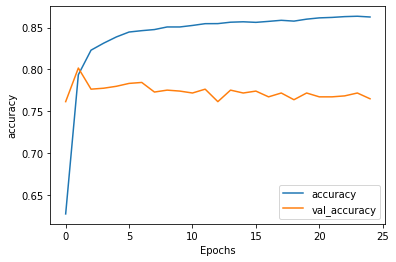

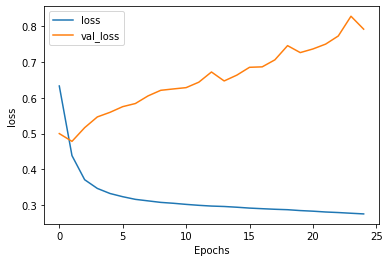

In [32]:
import matplotlib.pyplot as plt
def plot_graph(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel('Epochs')
  plt.ylabel(string)
  plt.legend([string,'val_'+string])
  plt.show()

plot_graph(history, 'accuracy')
plot_graph(history, 'loss')

#Write a function to predict the sentiment of reviews

In [37]:
new_reviews = validation_reviews[:15]
new_reviews


['b"it \'s a charming and often affecting journey . "',
 "b'unflinchingly bleak and desperate '",
 "b'allows us to hope that nolan is poised to embark a major career as a commercial yet inventive filmmaker . '",
 'b"the acting , costumes , music , cinematography and sound are all astounding given the production \'s austere locales . "',
 'b"it \'s slow -- very , very slow . "',
 "b'although laced with humor and a few fanciful touches , the film is a refreshingly serious look at young women . '",
 "b'a sometimes tedious film . '",
 'b"or doing last year \'s taxes with your ex-wife . "',
 'b"you do n\'t have to know about music to appreciate the film \'s easygoing blend of comedy and romance . "',
 'b"in exactly 89 minutes , most of which passed as slowly as if i \'d been sitting naked on an igloo , formula 51 sank from quirky to jerky to utter turkey . "',
 "b'the mesmerizing performances of the leads keep the film grounded and keep the audience riveted . '",
 "b'it takes a strange kind

In [38]:
def predict_review(model, reviews):
  padding_type = 'post'
  sample_sequences = tokenizer.texts_to_sequences(reviews)
  reviews_padded = pad_sequences(sample_sequences, padding=padding_type, maxlen=max_length)
  classes = model.predict(reviews_padded)
  for r,c in zip(reviews, classes):
    print(r, c, '\n')

predict_review(model ,new_reviews)


b"it 's a charming and often affecting journey . " [0.99985164] 

b'unflinchingly bleak and desperate ' [0.02669868] 

b'allows us to hope that nolan is poised to embark a major career as a commercial yet inventive filmmaker . ' [0.99109495] 

b"the acting , costumes , music , cinematography and sound are all astounding given the production 's austere locales . " [0.99988616] 

b"it 's slow -- very , very slow . " [0.06218523] 

b'although laced with humor and a few fanciful touches , the film is a refreshingly serious look at young women . ' [0.99999934] 

b'a sometimes tedious film . ' [0.05466375] 

b"or doing last year 's taxes with your ex-wife . " [0.24012893] 

b"you do n't have to know about music to appreciate the film 's easygoing blend of comedy and romance . " [0.9990753] 

b"in exactly 89 minutes , most of which passed as slowly as if i 'd been sitting naked on an igloo , formula 51 sank from quirky to jerky to utter turkey . " [0.00146508] 

b'the mesmerizing performances

#Define a function to train and show the results of model

In [41]:
def fit_model_and_show_results(model1, review):
  num_epochs = 25
  history = model1.fit(training_padded, training_labels_final, epochs=num_epochs, validation_data=(validation_padded, validation_labels_final))  
  plot_graph(history, 'accuracy')
  plot_graph(history, 'loss')
  predict_review(model1 ,new_reviews)

#Use a CNN

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 50, 16)            64000     
                                                                 
 conv1d_1 (Conv1D)           (None, 46, 128)           10368     
                                                                 
 global_average_pooling1d_4   (None, 128)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_6 (Dense)             (None, 6)                 774       
                                                                 
 dense_7 (Dense)             (None, 1)                 7         
                                                                 
Total params: 75,149
Trainable params: 75,149
Non-trainable params: 0
__________________________________________________

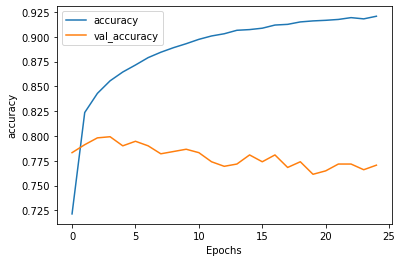

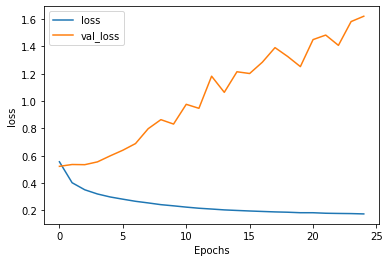

b"it 's a charming and often affecting journey . " [1.] 

b'unflinchingly bleak and desperate ' [0.0437015] 

b'allows us to hope that nolan is poised to embark a major career as a commercial yet inventive filmmaker . ' [1.] 

b"the acting , costumes , music , cinematography and sound are all astounding given the production 's austere locales . " [1.] 

b"it 's slow -- very , very slow . " [0.0437015] 

b'although laced with humor and a few fanciful touches , the film is a refreshingly serious look at young women . ' [1.] 

b'a sometimes tedious film . ' [0.0437015] 

b"or doing last year 's taxes with your ex-wife . " [0.95745206] 

b"you do n't have to know about music to appreciate the film 's easygoing blend of comedy and romance . " [1.] 

b"in exactly 89 minutes , most of which passed as slowly as if i 'd been sitting naked on an igloo , formula 51 sank from quirky to jerky to utter turkey . " [0.0437015] 

b'the mesmerizing performances of the leads keep the film grounded and ke

In [42]:
model_cnn = tf.keras.Sequential([
  tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
  tf.keras.layers.Conv1D(128, 5, activation='relu'),
  tf.keras.layers.GlobalAveragePooling1D(),
  tf.keras.layers.Dense(6, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

model_cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
model_cnn.summary()

fit_model_and_show_results(model_cnn, review)

#Use a GRU

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 50, 16)            64000     
                                                                 
 bidirectional (Bidirectiona  (None, 128)              31488     
 l)                                                              
                                                                 
 dense_8 (Dense)             (None, 6)                 774       
                                                                 
 dense_9 (Dense)             (None, 1)                 7         
                                                                 
Total params: 96,269
Trainable params: 96,269
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
1250/1250 [==============================] - 53s 40ms/step - loss: 0.4777 - accuracy: 0.7498 - val_loss: 

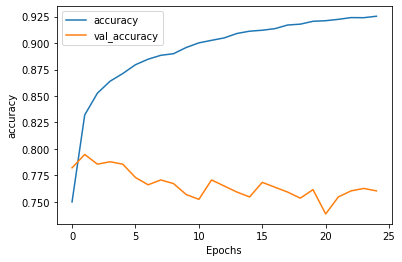

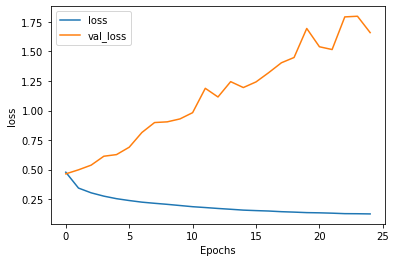

b"it 's a charming and often affecting journey . " [1.] 

b'unflinchingly bleak and desperate ' [8.97542e-07] 

b'allows us to hope that nolan is poised to embark a major career as a commercial yet inventive filmmaker . ' [0.849615] 

b"the acting , costumes , music , cinematography and sound are all astounding given the production 's austere locales . " [0.9999949] 

b"it 's slow -- very , very slow . " [0.452429] 

b'although laced with humor and a few fanciful touches , the film is a refreshingly serious look at young women . ' [0.99999976] 

b'a sometimes tedious film . ' [3.4170077e-06] 

b"or doing last year 's taxes with your ex-wife . " [0.999984] 

b"you do n't have to know about music to appreciate the film 's easygoing blend of comedy and romance . " [0.9999918] 

b"in exactly 89 minutes , most of which passed as slowly as if i 'd been sitting naked on an igloo , formula 51 sank from quirky to jerky to utter turkey . " [0.5111468] 

b'the mesmerizing performances of the lead

In [43]:
model_gru = tf.keras.Sequential([
  tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
  tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64)),
  tf.keras.layers.Dense(6, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

model_gru.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
model_gru.summary()

fit_model_and_show_results(model_gru, review)

#Use a LSTM

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 50, 16)            64000     
                                                                 
 bidirectional_1 (Bidirectio  (None, 32)               4224      
 nal)                                                            
                                                                 
 dense_10 (Dense)            (None, 6)                 198       
                                                                 
 dense_11 (Dense)            (None, 1)                 7         
                                                                 
Total params: 68,429
Trainable params: 68,429
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
1250/1250 [==============================] - 34s 25ms/step - loss: 0.4799 - accuracy: 0.7488 - val_loss: 

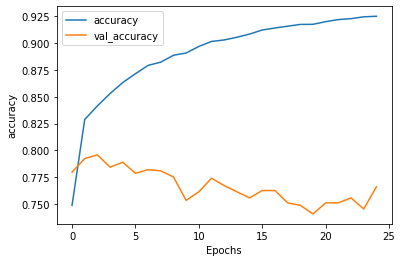

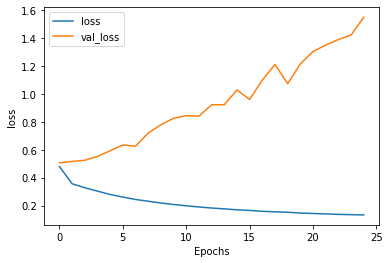

b"it 's a charming and often affecting journey . " [0.99999124] 

b'unflinchingly bleak and desperate ' [4.4711223e-06] 

b'allows us to hope that nolan is poised to embark a major career as a commercial yet inventive filmmaker . ' [0.99891007] 

b"the acting , costumes , music , cinematography and sound are all astounding given the production 's austere locales . " [0.9998591] 

b"it 's slow -- very , very slow . " [0.76430035] 

b'although laced with humor and a few fanciful touches , the film is a refreshingly serious look at young women . ' [0.9999561] 

b'a sometimes tedious film . ' [0.00488862] 

b"or doing last year 's taxes with your ex-wife . " [0.9976383] 

b"you do n't have to know about music to appreciate the film 's easygoing blend of comedy and romance . " [0.9990778] 

b"in exactly 89 minutes , most of which passed as slowly as if i 'd been sitting naked on an igloo , formula 51 sank from quirky to jerky to utter turkey . " [1.896681e-07] 

b'the mesmerizing performanc

In [44]:
model_lstm = tf.keras.Sequential([
  tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
  tf.keras.layers.Dense(6, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
model_lstm.summary()

fit_model_and_show_results(model_lstm, review)

#Use a LSTMs

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 50, 16)            64000     
                                                                 
 bidirectional_2 (Bidirectio  (None, 50, 32)           4224      
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 32)               6272      
 nal)                                                            
                                                                 
 dense_12 (Dense)            (None, 6)                 198       
                                                                 
 dense_13 (Dense)            (None, 1)                 7         
                                                                 
Total params: 74,701
Trainable params: 74,701
Non-trai

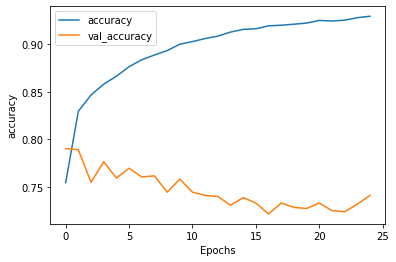

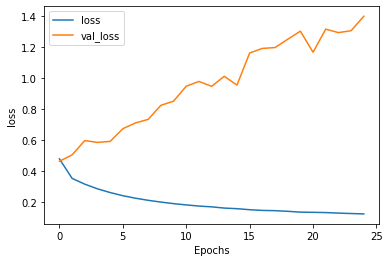

b"it 's a charming and often affecting journey . " [0.99998975] 

b'unflinchingly bleak and desperate ' [6.626789e-05] 

b'allows us to hope that nolan is poised to embark a major career as a commercial yet inventive filmmaker . ' [0.9051231] 

b"the acting , costumes , music , cinematography and sound are all astounding given the production 's austere locales . " [0.06014884] 

b"it 's slow -- very , very slow . " [0.00172156] 

b'although laced with humor and a few fanciful touches , the film is a refreshingly serious look at young women . ' [0.9999212] 

b'a sometimes tedious film . ' [0.00241649] 

b"or doing last year 's taxes with your ex-wife . " [0.8623433] 

b"you do n't have to know about music to appreciate the film 's easygoing blend of comedy and romance . " [0.04997241] 

b"in exactly 89 minutes , most of which passed as slowly as if i 'd been sitting naked on an igloo , formula 51 sank from quirky to jerky to utter turkey . " [8.78468e-05] 

b'the mesmerizing performance

In [45]:
model_lstms = tf.keras.Sequential([
  tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
  tf.keras.layers.Dense(6, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

model_lstms.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
model_lstms.summary()

fit_model_and_show_results(model_lstms, review)